# 10-1. 들어가며
![1](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-3-P-1.max-800x600.png)  

이번 시간에는 CAM(Class Activation Map)을 얻기 위한 방법 중 `기본 CAM`과 `Grad-CAM`을 구현해보고 이를 시각화해 보겠습니다. 그리고 CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해 보겠습니다.  

## 실습목표
***
1. Classification model로부터 CAM을 얻어낼 수 있다.  
2. CAM으로 물체의 위치를 찾을 수 있다.  
3. CAM을 시각화 비교할 수 있다.  

## 학습내용
***
1. CAM, Grad-CAM용 모델 준비하기  
2. CAM  
3. Grad-CAM  
4. Detection with CAM  

## 준비물
***
개인 실습 환경에 따라 경로를 수정, 터미널을 열고 프로젝트를 위한 디렉토리를 생성해 주세요.   
    $ mkdir -p ~/aiffel/class_activation_map  
    
클라우드 사용자라면 우측 하단의 Cloud shell을 열고 디렉토리를 생성해 주세요.  
    $ ln -s ~/data ~/aiffel/class_activation_map


***

# 10-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기  

**CAM(Class Activation Map)**은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

우리는 이번 시간에 두 가지를 모두 구현해 보겠습니다.
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

CAM은 **클래스에 대한 활성화 정도를 나타낸 지도**입니다. 따라서 기본적으로 우리의 모델은 **분류(classfication)**를 수행하는 모델이어야 합니다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

`Tensorflow Datasets`의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 `Cars196` 데이터셋을 사용하겠습니다. 이는 196종의 자동차 종류를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치정보인 **바운딩 박스(bounding box)** 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.  

- [Cars196 in Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/cars196)  



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**`cars196`** 데이터셋은 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성되어있습니다. **`tfds.load()`** 를 활용해서 데이터셋을 다운로드 해주세요.  

> (주의) 아래 데이터셋은 총 사이즈 1.8GB에 이르는 대용량 데이터셋입니다. 최초로 load()를 호출하는 경우 다운로드에 1시간 가량 소요될 수 있으므로, 최초 다운로드는 jupyter notebook을 통해 수행하시기를 권합니다.  


In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-train.tfrecord...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling cars196-test.tfrecord...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Dataset cars196 downloaded and prepared to /home/aiffel-dj40/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.


**`tfds.show_examples()`** 를 통해서 각 이미지의 클래스와 그 인덱스(index)를 확인할 수 있습니다.

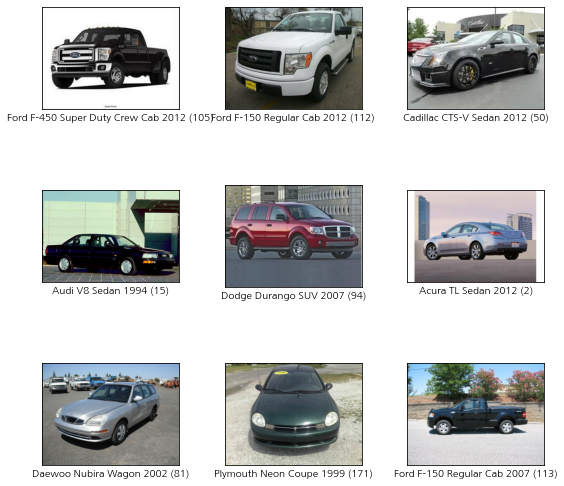

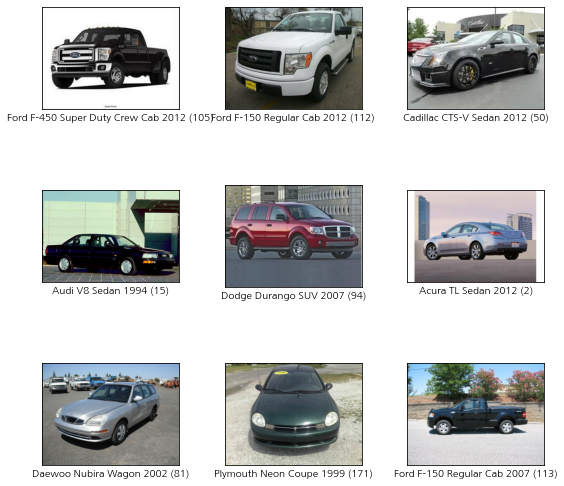

In [5]:
tfds.show_examples(ds_train, ds_info)

학습용 데이터셋 뿐만 아니라 평가용 데이터셋도 눈으로 확인해 보세요.

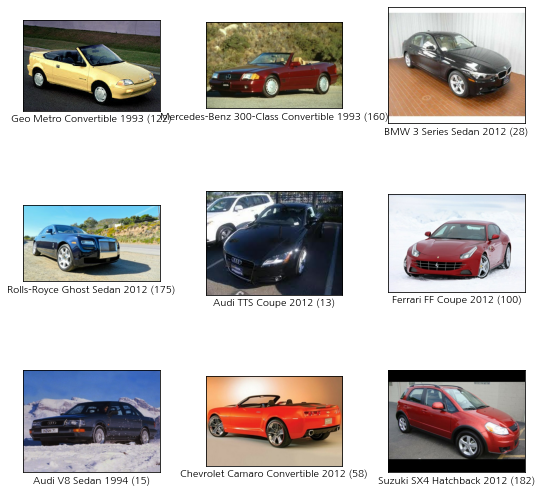

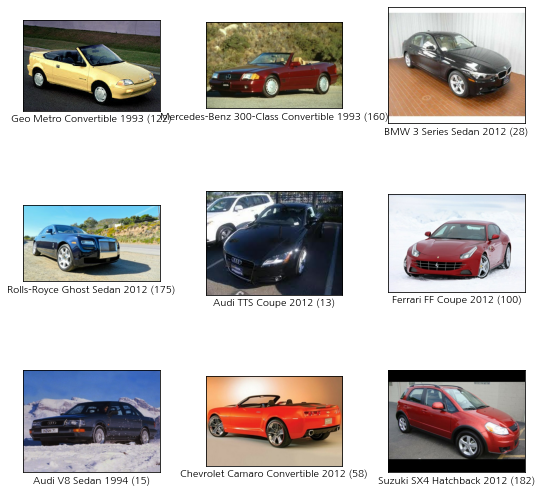

In [6]:
tfds.show_examples(ds_test, ds_info)

***

# 10-3. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

원본 이미지 위에 물체의 위치정보는 어떻게 시각화 하여 표시할 수 있을까요? 데이터셋의 메타 정보인 **`df_info`** 를 조회해 **`features`** 가 어떻게 구성되어 있는지 확인해 봅시다.

In [7]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

먼저 **`image`** 와 **`label`** 은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. **`bbox`** 는 무엇일까요? bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 **`BBoxFeature`** 이라는 타입으로 정의되어 있습니다.  
(참고) [BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)  

![bb](https://aiffelstaticprd.blob.core.windows.net/media/original_images/GC-3-P-2.jpg)  

**바운딩 박스를 표시하는 방법들**  

바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.  

- **'xywh'** 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.  
    - (예) `(x_center, y_center, width, height)`  
    - x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.   
    
- **'minmax'** 는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.  
    - (예) `(x_min, x_max, y_min, y_max)`  
    - 좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.   
    
- 위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.


**Q1. 주어진 데이터셋에서 `BBoxFeature` 타입으로 표기된 `bbox` 필드는 어떤 방식으로 바운딩박스를 라벨링하고 있나요?  (참고)로 제시된 텐서플로우 튜토리얼 링크를 통해 확인해 봅시다.**   

해당 bounding box는 minmax를 의미합니다. tfds의 경우 height를 첫번째 axis로 삼고있어 [minY, minX, maxY, maxX]를 의미하게 됩니다.

***

# 10-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 이번에는 미리 이미지넷(**`imagenet`**) 데이터에 훈련된 **`resnet50`** 을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.  

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.  

**구현해 보기**  

아래에서 직접 **`resnet50`** 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성해 주세요. CAM 모델의 구조가 생각나지 않는다면, Lecture 노드나 관련 내용을 참고해 완성해 보세요.  

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

아래 [코드 확인] 예시처럼 **`cam_model`** 을 만드셨다면 성공하신 겁니다. CAM 모델은 우리가 해왔던 분류 문제를 위한 모델과 크게 다른 점이 없습니다. 다만 마지막 fully connected layer 대신 GAP을 사용해주어야 합니다. 우리의 경우 **`keras.application`** 의 **`ResNet50`** 의 매개변수 **`pooling`** 에 **`'avg'`** 를 매개변수로 전달함으로써 쉽게 GAP 연산을 붙일 수 있습니다.  

- 참고: [tf.keras.applications.ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)  



아래에서 직접 만든 CAM모델을 확인해 주세요.

In [10]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

**Q2. CAM은 특성 맵(feature map)을 사용해 만듭니다. 위 레이어들 중 우리가 사용하는 특성 맵은 어떤 레이어의 출력값일까요? 해당 레이어의 이름을 찾아보세요.**  

conv5_block3_out의 output이 feature map이 됩니다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.

***

# 10-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

이제 학습을 위한 과정은 이전과 비슷합니다.  

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 **`normalize_and_resize_img()`** 에서 수행하며, 이를 포함하여 **`apply_normalize_on_dataset()`** 에서 배치를 구성합니다.  

**`input`** 에 이전과 다르게 **`bbox`** 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 **`normalize_and_resize_img`** 과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [11]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 124s 170ms/step - loss: 4.9807 - accuracy: 0.0607 - val_loss: 5.3109 - val_accuracy: 0.0174
Epoch 2/15
509/509 [==============================] - 104s 205ms/step - loss: 2.0364 - accuracy: 0.5589 - val_loss: 1.9445 - val_accuracy: 0.5280
Epoch 3/15
509/509 [==============================] - 84s 164ms/step - loss: 0.7753 - accuracy: 0.8498 - val_loss: 1.3035 - val_accuracy: 0.6551
Epoch 4/15
509/509 [==============================] - 84s 164ms/step - loss: 0.2439 - accuracy: 0.9694 - val_loss: 1.1343 - val_accuracy: 0.7002
Epoch 5/15
509/509 [==============================] - 85s 167ms/step - loss: 0.0725 - accuracy: 0.9963 - val_loss: 1.0457 - val_accuracy: 0.7229
Epoch 6/15
509/509 [==============================] - 88s 173ms/step - loss: 0.0410 - accuracy: 0.9980 - val_loss: 1.0170 - val_accuracy: 0.7337
Epoch 7/15
509/509 [==============================] - 87s 171ms/step - loss: 0.0327 - accuracy: 0.9981 - val_loss: 1.0068 - val_

학습시킨 가중치를 저장해 주겠습니다.

In [15]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


***

# 10-6. CAM

> 이제 학습한 모델을 활용하여 CAM을 생성해 볼 것입니다. 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권합니다.

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

이제 학습된 모델에서 CAM을 생성해 봅시다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, **`get_one()`** 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

173


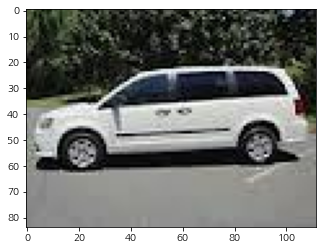

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이제 데이터가 준비되었으니 CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러와 봅시다.

In [3]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

CAM을 생성하기 위해서는 **(1) 특성 맵, (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값**이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것입니다. 이를 고려해서 `model`과 `item`을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.  

**`generate_cam()`** 을 구현하기 위해 아래에서는 **`conv_ouputs`** 와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 **`resize`** 해주었습니다.

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있습니다. 생각보다 위치를 정확하게 표현하고 있습니다.

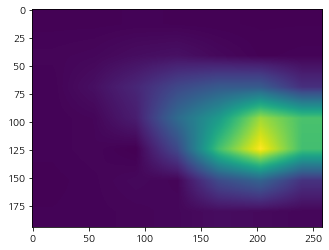

In [24]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이렇게 그려진 CAM 이미지를 원본 이미지와 합쳐 봅시다.

In [25]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

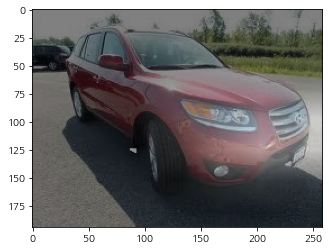

In [26]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

어떤가요? 생성된 CAM이 차종을 식별하는데 중요한 이미지 부분을 잘 포착하고 있나요? 주로 차량의 전면 엠블럼이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 차종을 식별할 때 유의해서 보는 부분과 일맥상통하다는 것을 확인할 수 있을 것입니다.

***

# 10-7. Grad-CAM

이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 **`cam_model`** 을 그대로 활용합시다.

우선 새로운 이미지를 뽑아봅시다.

130


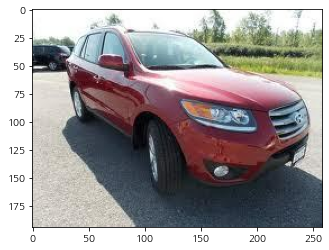

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

**`grad_cam`** 은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(**`weights`**)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 **`cam_image`** 를 얻게 됩니다.  

위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 **`activation_layer`** 를 뽑아서 쓸 수 있도록 **`activation_layer`** 의 이름을 받고 이를 활용해야 합니다.

아래 **`generate_grad_cam()`** 에서는 원하는 레이어의 **`output`** 과 특정 클래스의 prediction 사이의 그래디언트 **`grad_val`** 을 얻고 이를 **`weights`** 로 활용합니다.

In [28]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 **`cam_model.summary()`** 에서 찾을 수 있습니다.

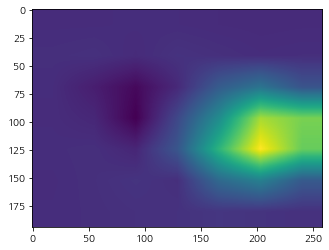

In [29]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

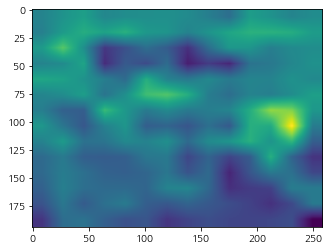

In [30]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

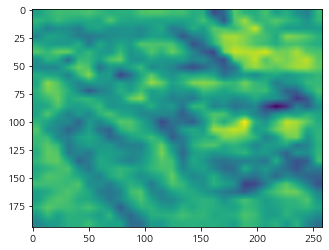

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

***

# 10-8. Detection with CAM

## 바운딩 박스
***
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

120


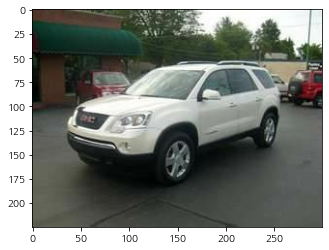

In [32]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

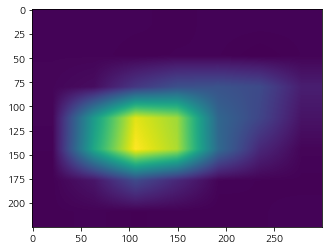

In [33]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전의 **`generate_cam`** 을 활용해서 CAM 이미지를 뽑아봅시다. 아래 **`get_bbox()`** 함수는 바운딩 박스를 만들기 위해서 **`score_thresh`** 를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 **`findContours()`** 와 **`minAreaRect()`** 로 사각형을 찾습니다. 이때 **`rotated_rect`** 라는 회전된 바운딩 박스를 얻을 수 있습니다. **`boxPoints()`** 로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 **`int`** 자료형으로 변환해 줍니다.

In [34]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

아래에서 **`cam_image`** 를 통해 **`bbox`** 를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있습니다.

In [35]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 16,  68],
       [295,  37],
       [310, 177],
       [ 31, 208]])

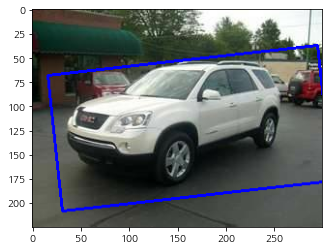

In [36]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

## Intersection Over Union
***
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있습니다. 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까요?

![IOU](https://aiffelstaticprd.blob.core.windows.net/media/images/GC-3-P-3.max-800x600.jpg)  

**IoU(Intersection over Union)** 는 두 개 영역의 합집합인 **"union"** 영역으로 교집합 영역인 **"intersection"** 영역의 넓이를 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.

자세한 내용이 궁금하시다면 아래 링크를 참조하세요.

- [C4W3L06 Intersection Over Union](https://www.youtube.com/watch?v=ANIzQ5G-XPE)

In [37]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

위에서 구했던 rect를 minmax bbox 형태로 치환해 봅시다.

In [38]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.16444444444444445,
 0.05333333333333334,
 0.9244444444444444,
 1.0333333333333334]

이 데이터의 ground truth bbox를 확인해 봅시다.

In [39]:
item['bbox']

array([0.22666667, 0.11333334, 0.83111113, 0.87      ], dtype=float32)

어떤가요? CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷하게 얻어졌나요? 얼마나 유사한지를 IoU를 계산해서 확인해 봅시다.

In [40]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [41]:
get_iou(pred_bbox, item['bbox'])

0.6140748521054981

***

# 10-9. 프로젝트: CAM을 만들고 평가해 보자

## CAM 구현하기
***
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

    def generate_cam(model, item):
        cam_image = None
        # TODO: generate cam image
        return cam_image

In [4]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

189


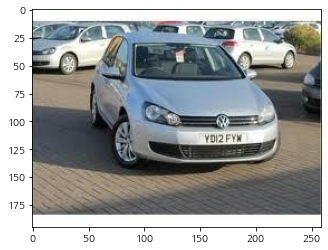

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

2) 만든 함수로 CAM 이미지를 생성합시다.

    cam_image = generate_cam(cam_model, item)
    plt.imshow(cam_image)

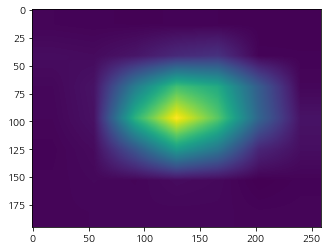

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 **`visualize_cam_on_image()`** 함수를 만들어보세요.  

- 참고: [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

    def visualize_cam_on_image(image, cam_image):
        # TODO: blend image
        merged_image = None
        return merged_image

In [28]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

    # visualize_cam_on_image() 함수 사용

    type(item['image'].numpy())

    origin_image = item['image'].numpy().astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

    blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
    plt.imshow(blended_image)

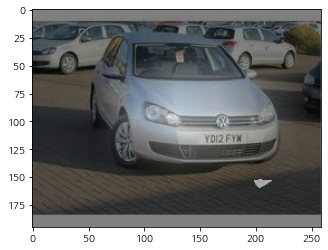

In [29]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기
***
1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

    def generate_grad_cam(model, activation_layer, item):
        grad_cam_image = None
        # TODO: generate grad_cam_image

        return grad_cam_image

In [30]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

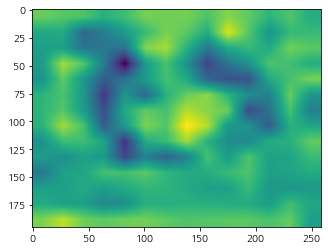

In [31]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

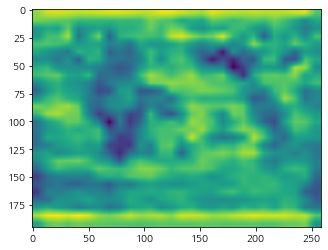

In [32]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

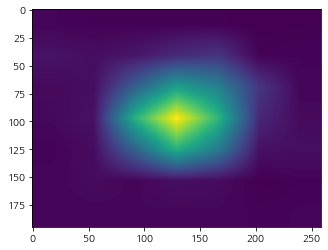

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

3) 위에서 만든 이미지 `visualize_cam_on_image()` 함수로 이미지를 시각화해 보세요. 

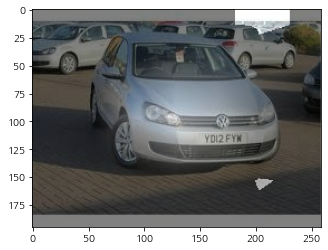

In [34]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 바운딩 박스 구하기
***
1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

In [35]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [36]:
image = copy.deepcopy(item['image'])

rect_cam = get_bbox(cam_image)
rect_cam

array([[ 53,  27],
       [236,  21],
       [240, 147],
       [ 57, 153]])

In [37]:
rect_grad_cam = get_bbox(grad_cam_image)
rect_grad_cam

array([[ 56,  24],
       [229,  24],
       [229, 151],
       [ 56, 151]])

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.  

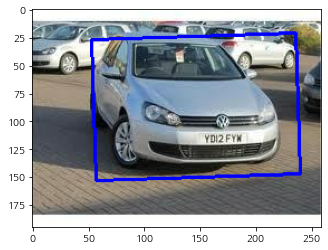

In [38]:
# cam 이미지 바운딩 박스
image_cam = cv2.drawContours(image,[rect_cam],0,(0,0,255),2)
plt.imshow(image_cam)

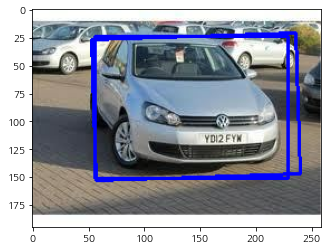

In [39]:
# grad_cam 이미지 바운딩 박스
image_grad_cam = cv2.drawContours(image,[rect_grad_cam],0,(0,0,255),2)
plt.imshow(image_grad_cam)

## IoU구하기
***
1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

    def get_iou(gt_bbox, pred_bbox):
        iou = None
        # TODO: get iou between two bbox
        return iou

In [40]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [41]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [42]:
# cam 이미지 예측 바운딩 박스
pred_bbox_cam = rect_to_minmax(rect_cam, item['image'])
pred_bbox_cam

[0.1076923076923077,
 0.20463320463320464,
 0.7846153846153846,
 0.9266409266409267]

In [43]:
# grad_cam 이미지 예측 바운딩 박스
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
pred_bbox_grad_cam

[0.12307692307692308,
 0.21621621621621623,
 0.7743589743589744,
 0.8841698841698842]

In [44]:
# 실제 바운딩 박스
item['bbox']

array([0.10769231, 0.2007722 , 0.74358976, 0.8687259 ], dtype=float32)

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [45]:
iou_cam = get_iou(pred_bbox_cam, item['bbox'])
iou_grad_cam = get_iou(pred_bbox_grad_cam, item['bbox'])
print('CAM 이미지 바운딩 박스 IoU: ', iou_cam)
print('Grad-CAM 이미지 바운딩 박스 IoU: ', iou_grad_cam)

CAM 이미지 바운딩 박스 IoU:  0.8597226764685207
Grad-CAM 이미지 바운딩 박스 IoU:  0.8900931332455178


## Grad_CAM의 IoU가 좀 높은 것을 확인함.

***

# 루브릭 평가

|평가문항|상세기준|
|:---|:---|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|